## Twitter Sentiment Analysis

Semtiment analysis is the process of understanding the opinion of an author about a subject.

An opinion, also called polarity can be of three types: Positive, Neutral and Negative.Most brands use sentiment analysis to understand how their customers interact and feel about their brand.Sentiment Analysis is also used in Brand monitoring, Cutomer service, Product Analysis and Market research.

Twitter is a gold mine of data. Twitter is an amazing micro blogging tool and an extraordinary communication medium. In addition, it can also be an amazing open mine for text and social web analyses.

In this project, we will be working on twitter dataset that has 1.6 million tweets and do the sentiment analysis of the tweets.

## Setup

In [2]:
import pandas as pd #fordata manipulation, analysis and cleaning
import numpy as np #computing and data manipulation
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
import re
from collections import Counter
from bs4 import BeautifulSoup # for parsing HTML data
from nltk.tokenize import WordPunctTokenizer, word_tokenize #to extract the tokens from string of words or sentences 
import collections
from sklearn.naive_bayes import MultinomialNB
from PIL import Image
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix 
from sklearn.svm import LinearSVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer   
import warnings
warnings.filterwarnings("ignore")

## Importing the Dataset

Now that the setup is done, Let us import the dataset and have a look at it.

In [4]:
data_columns = ["target", "id", "date", "query", "user", "text"]
data_encoding = "ISO-8859-1"
data = pd.read_csv('../training_data.csv', encoding = data_encoding ,names=data_columns)
data.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   query   1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


The dataset has 1.6 million records with 6 columns as follows:

    - sentiment: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)    
    - ids: The id of the tweet    
    - date: the date of the tweet    
    - query: The query. If there is no query, then this value is NO_QUERY.
    - user: the user that tweeted
    - text: the text of the tweet

Now, Let us have a look at how many positive and negative tweets we have in our data.

In [6]:
data.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

From the above two steps it is clear that the dataset has 1.6 million entries
There are no null entries
The "sentiment" column suggests that the 50% of the training data is with negative label and another 50% with positive label. There are no tweets that are tagged as neautral

Changing the values for convenience sake. So now NEGATIVE represents the negative tweets, POSITIVE represents the positive tweets and NEUTRAL represents neutral tweets

Here, I am making a new dictionary which maps the target variable to the sentiment.

In [7]:
sentiment_dict = [
    {'target' : 0 , 'sentiment' : 'NEGATIVE'},
    {'target' : 4 , 'sentiment' : 'POSITIVE'},
    {'target' : 2 , 'sentiment' : 'NEUTRAL'}
]

In [10]:
sentiment_dictionary = pd.DataFrame(sentiment_dict)

Now that we have two datasets, let us perfoem a left join and merge both of them based on the target, since target is the common column.

In [11]:
dataset = pd.merge(data,sentiment_dictionary , on ='target', how='left')

In [12]:
dataset.head()

,target,id,date,query,user,text,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,NEGATIVE
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,NEGATIVE
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,NEGATIVE
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",NEGATIVE


Now, going further we will drop the extra columns that we will not need for further analysis and focus only on the relevant columns

In [13]:
dataset.drop(['target','id','date','query','user'],axis=1,inplace=True)

In [14]:
dataset.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE
1,is upset that he can't update his Facebook by ...,NEGATIVE
2,@Kenichan I dived many times for the ball. Man...,NEGATIVE
3,my whole body feels itchy and like its on fire,NEGATIVE
4,"@nationwideclass no, it's not behaving at all....",NEGATIVE


### Distribution of tweets based on the sentiment of the tweet

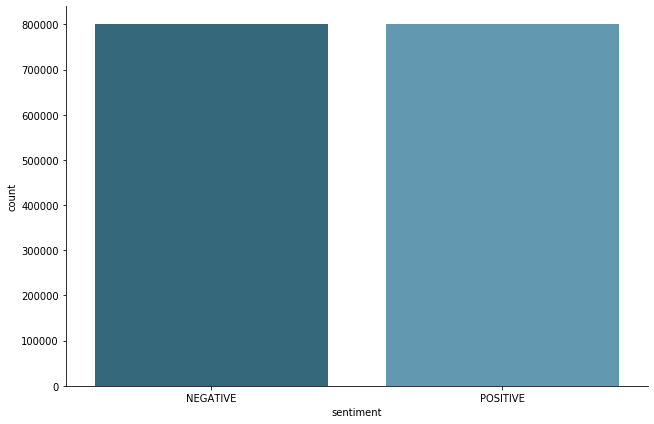

In [15]:
sns.factorplot(x="sentiment", data=dataset, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

Let us have a look at the tweets with negative sentiment.

In [16]:
dataset[dataset.sentiment == "NEGATIVE"].head(10)

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE
1,is upset that he can't update his Facebook by ...,NEGATIVE
2,@Kenichan I dived many times for the ball. Man...,NEGATIVE
3,my whole body feels itchy and like its on fire,NEGATIVE
4,"@nationwideclass no, it's not behaving at all....",NEGATIVE
5,@Kwesidei not the whole crew,NEGATIVE
6,Need a hug,NEGATIVE
7,@LOLTrish hey long time no see! Yes.. Rains a...,NEGATIVE
8,@Tatiana_K nope they didn't have it,NEGATIVE
9,@twittera que me muera ?,NEGATIVE


Coming to the tweets with positive sentiment.

In [17]:
dataset[dataset.sentiment == "POSITIVE"].head(10)

,text,sentiment
800000,I LOVE @Health4UandPets u guys r the best!!,POSITIVE
800001,im meeting up with one of my besties tonight! ...,POSITIVE
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",POSITIVE
800003,Being sick can be really cheap when it hurts t...,POSITIVE
800004,@LovesBrooklyn2 he has that effect on everyone,POSITIVE
800005,@ProductOfFear You can tell him that I just bu...,POSITIVE
800006,@r_keith_hill Thans for your response. Ihad al...,POSITIVE
800007,"@KeepinUpWKris I am so jealous, hope you had a...",POSITIVE
800008,"@tommcfly ah, congrats mr fletcher for finally...",POSITIVE
800009,@e4VoIP I RESPONDED Stupid cat is helping me ...,POSITIVE


By looking at the above entries for each type of sentiment, we can observe that all the negative tweets range from ids 0~799999 index, and the positive tweets range from 800000 to the end of the dataset

## Data Preparation

Let us see the mean length and distribution of the lengths of tweets

In [18]:
dataset['length_of_tweets'] = [len(t) for t in dataset.text]

In [19]:
dataset['length_of_tweets'].mean()

74.09011125

In [20]:
dataset['length_of_tweets'].median()

69.0

The average lengths of tweets is 74 characters.

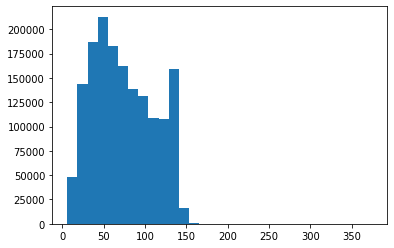

In [22]:
plt.hist(dataset['length_of_tweets'], bins = 30)
plt.show()

As it is an old dataset, the length of most of the tweets are within the range of 140 characters, which is now 280 characters.

Let us have a look at the final dataset

In [23]:
dataset.head(100)

,text,sentiment,length_of_tweets
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE,115
1,is upset that he can't update his Facebook by ...,NEGATIVE,111
2,@Kenichan I dived many times for the ball. Man...,NEGATIVE,89
3,my whole body feels itchy and like its on fire,NEGATIVE,47
4,"@nationwideclass no, it's not behaving at all....",NEGATIVE,111
...,...,...,...
95,Strider is a sick little puppy http://apps.fa...,NEGATIVE,85
96,"so rylee,grace...wana go steve's party or not?...",NEGATIVE,112
97,"hey, I actually won one of my bracket pools! T...",NEGATIVE,81
98,"@stark YOU don't follow me, either and i work...",NEGATIVE,55


### Data Cleaning

**Removing @mentions**

From the above table, we can see that the tweets commonly have @mention.
We dont need the mentioned user name to which the treat is addressed to in order to find the sentiment behind the tweet. So we will start by removing it.

In [24]:
dataset.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [25]:
re.sub(r'@[A-Za-z0-9]+','',dataset.text[0])

" http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

**Removing URL**

Now that we have dealt with the mentions in the tweet,next we will focus on the URL links.
We do not need URL links to find the sentiment behind the tweet.

In [27]:
dataset.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [28]:
re.sub('https?://[A-Za-z0-9./]+','',dataset.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

**Removing # from hashtags**


Sometimes hashtags can provide useful information about the tweet. So we will remove the # sign (along with other special characters) and keep the text.

In [29]:
dataset.text[83]

'@markhardy1974 Me too  #itm'

In [30]:
re.sub("[^a-zA-Z]", " ", dataset.text[83])

' markhardy     Me too   itm'

**Handling Negations**

There are words like didn't , wasn't in the tweets. For the sake of convenience, we would handle these negations and change them to did not and was not , etc

In [31]:
dataset.text[8]

"@Tatiana_K nope they didn't have it "

In [32]:
re.sub("didn't", "did not", dataset.text[8])

'@Tatiana_K nope they did not have it '

**Decoding HTML to generat text**

Now, in the above table we can also see that the tweets have '&amp','&quot', etc in the text field.
On googling, it looks like HTML encoding has not been converted to text, which may be the reason.

Decoding HTML to general text will be my first step of data preparation. I will use BeautifulSoup for this.

In [33]:
dataset.text[103]

'watching &quot;House&quot; '

In [34]:
print(BeautifulSoup(dataset.text[103], 'lxml').get_text())

watching "House" 


## Data Preprocessing Function

Now, let's define a data cleaning function, that will do all the above mentioned data claening. Then we will apply it to the whole dataset.

In [35]:
token = WordPunctTokenizer()

mention_pattern = r'@[A-Za-z0-9_]+'
https_pattern = r'https?://[^ ]+'
www_pattern = r'www.[^ ]+'
combined_pattern = r'|'.join((mention_pattern, https_pattern,www_pattern))
negative_words = {"couldn't":"could not","shouldn't":"should not","mightn't":"might not","can't":"can not","aren't":"are not", "isn't":"is not", "wasn't":"was not", "weren't":"were not","haven't":"have not","hasn't":"has not","hadn't":"had not","don't":"do not", "doesn't":"does not","won't":"will not","wouldn't":"would not", "didn't":"did not", "mustn't":"must not"}
negative = re.compile(r'\b(' + '|'.join(negative_words.keys()) + r')\b') # to simplify negative words

def text_preprocess(text):
    text= BeautifulSoup(text, 'lxml').get_text() #decoding HTML to generate text
    lower_case = text.lower() #making everything lowercase
    clean_text = re.sub(combined_pattern, '', lower_case) # removing the patterns for mentions, URLs
    simple_words = negative.sub(lambda x: negative_words[x.group()], clean_text)  # simplifying negative words
    letters = re.sub("[^a-zA-Z]", " ", simple_words)
    words = [x for x  in token.tokenize(letters) if len(x) > 1]  #removing white space
    return (" ".join(words)).strip() #joining words

**Checking if the above function is doing its job**

Below is the text for the first 20 recors before processing

In [38]:
dataset.text[:20]

0     @switchfoot http://twitpic.com/2y1zl - Awww, t...
1     is upset that he can't update his Facebook by ...
2     @Kenichan I dived many times for the ball. Man...
3       my whole body feels itchy and like its on fire 
4     @nationwideclass no, it's not behaving at all....
5                         @Kwesidei not the whole crew 
6                                           Need a hug 
7     @LOLTrish hey  long time no see! Yes.. Rains a...
8                  @Tatiana_K nope they didn't have it 
9                             @twittera que me muera ? 
10          spring break in plain city... it's snowing 
11                           I just re-pierced my ears 
12    @caregiving I couldn't bear to watch it.  And ...
13    @octolinz16 It it counts, idk why I did either...
14    @smarrison i would've been the first, but i di...
15    @iamjazzyfizzle I wish I got to watch it with ...
16    Hollis' death scene will hurt me severely to w...
17                                 about to file

In [42]:
sample = dataset.text[:20]
clean_sample = []
for i in sample:
    clean_sample.append(text_preprocess(i))

Below are the first 20 tweets after the processing. Looks like the function did a pretty good job.

In [43]:
clean_sample

['awww that bummer you shoulda got david carr of third day to do it',
 'is upset that he can not update his facebook by texting it and might cry as result school today also blah',
 'dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it not behaving at all mad why am here because can not see you all over there',
 'not the whole crew',
 'need hug',
 'hey long time no see yes rains bit only bit lol fine thanks how you',
 'nope they did not have it',
 'que me muera',
 'spring break in plain city it snowing',
 'just re pierced my ears',
 'could not bear to watch it and thought the ua loss was embarrassing',
 'it it counts idk why did either you never talk to me anymore',
 'would ve been the first but did not have gun not really though zac snyder just doucheclown',
 'wish got to watch it with you miss you and how was the premiere',
 'hollis death scene will hurt me severely to watch on film wry is directors cut no

## Preprocessing all the records

Looks like the function is doing its job and we can see the clean data. Similarly, we will preprocess all the records. The below preprocessing will take about 9-10 minutes. So till then, grab a cup of coffee and relax for a while :) 

In [44]:
%%time
print("Preprocessing the text...\n")
clean_data = []
for i in range(0,len(dataset)):
    if((i+1)%20000 == 0):
        print("%d tweets out of %d have been cleaned" % (i+1, len(dataset)))                                                                
    clean_data.append(text_preprocess(dataset['text'][i]))

Preprocessing the text...

20000 tweets out of 1600000 have been cleaned
40000 tweets out of 1600000 have been cleaned
60000 tweets out of 1600000 have been cleaned
80000 tweets out of 1600000 have been cleaned
100000 tweets out of 1600000 have been cleaned
120000 tweets out of 1600000 have been cleaned
140000 tweets out of 1600000 have been cleaned
160000 tweets out of 1600000 have been cleaned
180000 tweets out of 1600000 have been cleaned
200000 tweets out of 1600000 have been cleaned
220000 tweets out of 1600000 have been cleaned
240000 tweets out of 1600000 have been cleaned
260000 tweets out of 1600000 have been cleaned
280000 tweets out of 1600000 have been cleaned
300000 tweets out of 1600000 have been cleaned
320000 tweets out of 1600000 have been cleaned
340000 tweets out of 1600000 have been cleaned
360000 tweets out of 1600000 have been cleaned
380000 tweets out of 1600000 have been cleaned
400000 tweets out of 1600000 have been cleaned
420000 tweets out of 1600000 have bee

In [45]:
clean_dataset = pd.DataFrame(clean_data,columns=['text'])
clean_dataset['sentiment'] = dataset.sentiment
clean_dataset.head()

,text,sentiment
0,awww that bummer you shoulda got david carr of...,NEGATIVE
1,is upset that he can not update his facebook b...,NEGATIVE
2,dived many times for the ball managed to save ...,NEGATIVE
3,my whole body feels itchy and like its on fire,NEGATIVE
4,no it not behaving at all mad why am here beca...,NEGATIVE


In [46]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   text       1600000 non-null  object
 1   sentiment  1600000 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


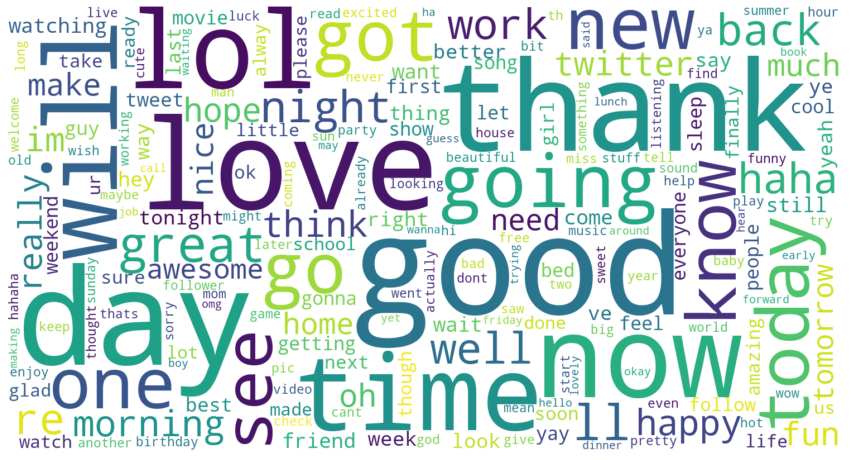

In [47]:
positive_tweets = clean_dataset[clean_dataset.sentiment == "POSITIVE"]
positive = []
for t in positive_tweets.text:
    positive.append(t)
positive = pd.Series(positive).str.cat(sep=' ')

wordcloud = WordCloud(background_color='white',max_font_size = 250,width=1500, height=800,collocations=False).generate(positive)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We can see that the words like good, love, now, time, day, lol, going, will, thank are used very often in the positive tweets.

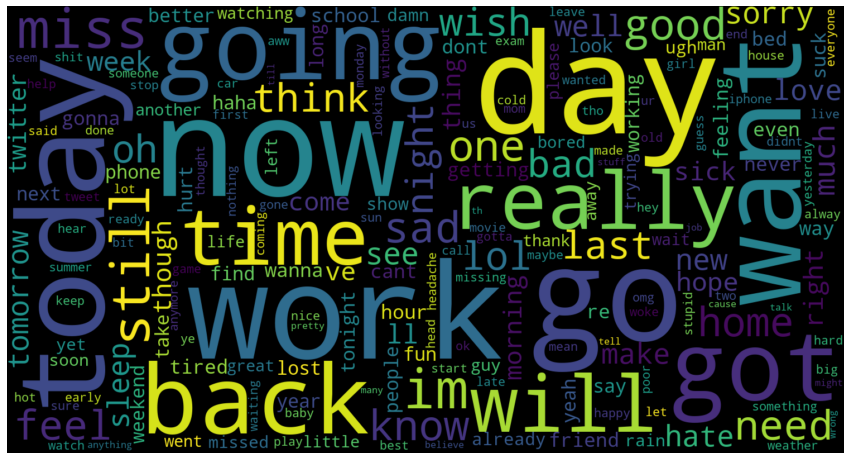

In [48]:
negative_tweets = clean_dataset[clean_dataset.sentiment == "NEGATIVE"]
negative = []
for t in negative_tweets.text:
    negative.append(t)
negative = pd.Series(negative).str.cat(sep=' ')

wordcloud = WordCloud(background_color='black',max_font_size = 250,width=1500, height=800,collocations=False).generate(negative)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In the negative tweets, words like day, now, today, work, time, going are used more often.
We can see that general words like day, now, today are used in both the kinds of tweets irrespective of the sentiments behind it.

Words like 'work' is often used in the neagtive tweets but not in the positive tweets. This suggests that many people express negative sentiment towards their work.

## Model Development

Now that the Data cleaning and EDA is done, Let's dive into the modeling.

**Splitting into Feature and Target**

First, we will have to split the dataset based on the feature and target. As we know, in this project we have to detect the sentiment of the tweet based on the text, the feature is the text column and the target is the sentiment.

In [53]:
X = clean_dataset.text # get all the text in x variable
y = clean_dataset.sentiment # get all the sentiments into y variable
print(X.shape) #print shape of x
print(y.shape) # print shape of y

(1600000,)
(1600000,)


**Splitting into Train and Test**

Now, we will split the data into training and testing data. I have taken 9:1 ratio which means that 90% of the data will be training data which will be used to develop the model and the rest 10% data will be testing data which will be used to evaluate the model performance.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state= 1)

In [57]:
X_train.shape ,y_train.shape, X_test.shape, y_test.shape

((1440000,), (1440000,), (160000,), (160000,))

Now, we will make use of the widely adopted word weighing scheme in text mining problems, known as term frequency and inverse document frequency (tf-idf).

Further, we will be training a Logistic Regression Classifier, Multinomial Naive Bayes classifier on tf-idf weighted word frequency features.

The idea behind it is to use histogram of words as the features for the text classification problems. In general, we first build the vocabulary of the corpus and then we generate word count vector from each file which is nothing but frequency of words present in the vocabulary. Then we will make use of this to train our model and analyze.

In [63]:
vect = TfidfVectorizer(analyzer = "word", ngram_range=(1,3)) #Transforming text to feature vectors
vect.fit(X_train) # fiting traning data to vect
X_train_dtm = vect.transform(X_train) # fiting traning data to vect
X_test_dtm = vect.transform(X_test) # fiting testing data to vect

## Logistic Regression

In [64]:
logisticRegr = LogisticRegression() #instantiating the logistic regression model 

In [65]:
logisticRegr.fit(X_train_dtm, y_train) # fit the model with training data

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
logisticRegr.score(X_train_dtm, y_train) #model training set evaluation

0.8621576388888889

In [67]:
y_pred_lr = logisticRegr.predict(X_test_dtm)  # predict the sentiments of test data

In [68]:
lr_outsample = logisticRegr.score(X_test_dtm, y_test) # out of sample model evaluation
lr_outsample

0.822575

In [69]:
cm_lr = confusion_matrix(y_test, y_pred_lr, labels = ['POSITIVE','NEGATIVE'])

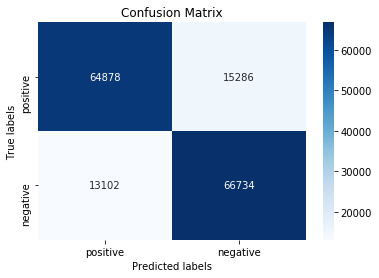

In [70]:
ax= plt.subplot()
sns.heatmap(cm_lr, annot=True, ax = ax,cmap='Blues', fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['positive', 'negative']); ax.yaxis.set_ticklabels(['positive', 'negative']);

The above confusion matrix shows that out of 160,000 tweets:
- 131,612 are correctly classified 
- Around 28,388 are incorrectly classified
- misclassification rate is 17%

## Naive Bayes

In [71]:
nb = MultinomialNB(alpha = 10)  #instantiating the Naive Bayes model 

In [72]:
nb.fit(X_train_dtm, y_train) # fiting the model with training data

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

In [73]:
nb.score(X_train_dtm, y_train) # model training set evaluation

0.8364506944444444

In [74]:
y_pred_nb = nb.predict(X_test_dtm) # predict the sentiments of test data

In [75]:
nb_outsample = nb.score(X_test_dtm, y_test) #model out of sample evaluation
nb_outsample

0.79744375

In [76]:
cm_nb = confusion_matrix(y_test, y_pred_nb,labels = ['POSITIVE','NEGATIVE'])

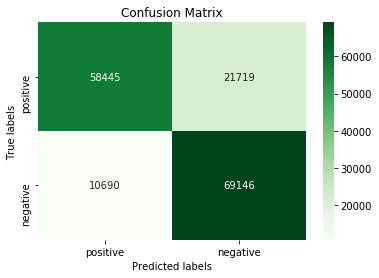

In [77]:
ax= plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax,cmap='Greens', fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['positive', 'negative']); ax.yaxis.set_ticklabels(['positive', 'negative']);

## Decision Tree

In [78]:
#decision_tree = DecisionTreeClassifier(random_state=12)  #instantiating the decision tree model 

In [79]:
#decision_tree.fit(X_train_dtm,y_train) # fiting the model with training data